<a href="https://colab.research.google.com/github/StefanHubner/MachineLearningEconomics/blob/main/CAPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
library(tidyverse)

path <- "https://raw.githubusercontent.com/StefanHubner/MachineLearningEconomics/main/data/stocks/returns.csv"
returns <- read_csv(path, show_col_types = FALSE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


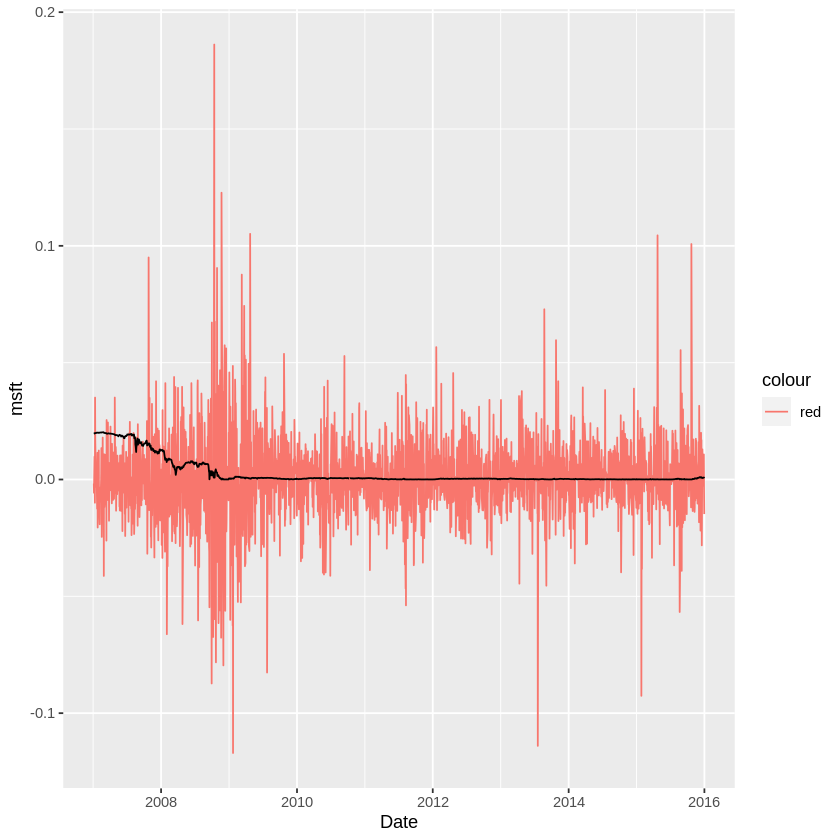

In [ ]:
ggplot(returns) +
   geom_line(aes(x = Date, y = msft, color = "red")) +
   geom_line(aes(x = Date, y = Rf))

In [ ]:
# tilde indicates a formula, . is a placeholder for the matched variables in the across fct
excess <- returns %>%
  mutate(across(-Date, ~ . - Rf)) %>%
  filter(Date >= as.Date("2014-01-01")) %>%
  select(-Rf, -Date) %>%
  drop_na()


mu <- colMeans(as.matrix(excess))
sigma <- cov(as.matrix(excess))

In [ ]:
optvar <- function(r) {
  # targeted daily returns
  R <- exp(log(1 + r) / 252) - 1
  R

  # optimal portfolio weights
  x <-  R * (solve(sigma) %*% mu) / ((mu %*% solve(sigma) %*% mu)[1])

  # expected daily returns and daily volatility (s.d.) of portfolio
  mu_p <- (t(x) %*% mu)[1]
  sigma_p <- sqrt(t(x) %*% sigma %*% x)[1]
  sigma_p <- R/sqrt(t(mu) %*% solve(sigma) %*% mu)

  # return expected annual returns and annual volatility
  c((1 + mu_p)^252 - 1, sigma_p * sqrt(252))
}

mu_p <- seq(0, 0.2, length.out = 20)
frontier <- data.frame(t(sapply(FUN = optvar, mu_p)))
names(frontier) <- c("mu_p", "sigma_p")

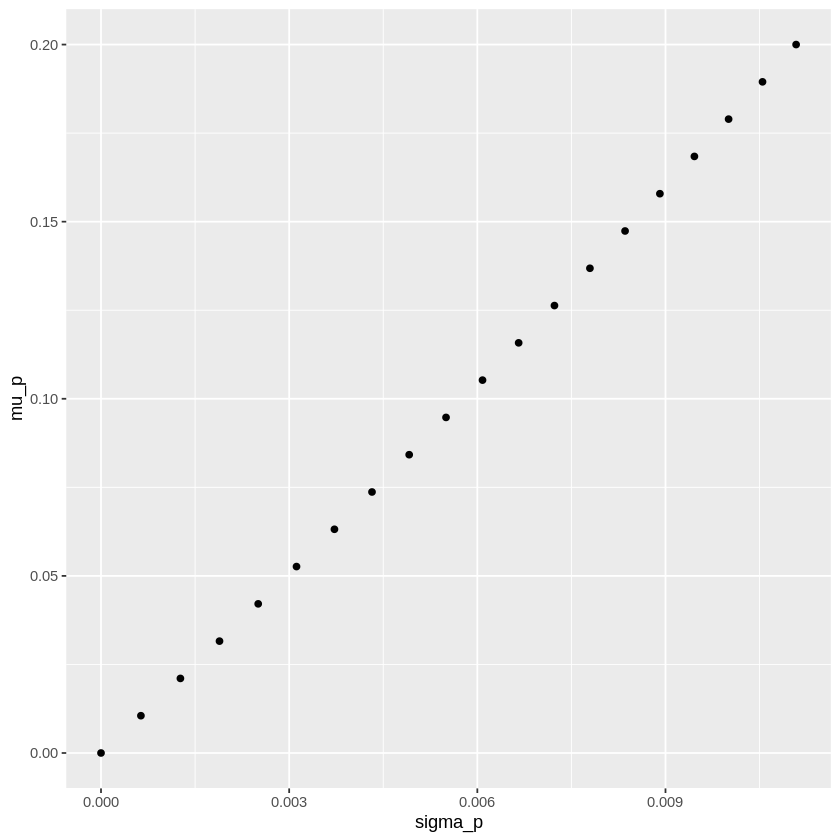

In [ ]:
ggplot(frontier, aes(x = sigma_p, y = mu_p)) +
  geom_point()

In [ ]:
optvar.constr <- function(r) {
  # targeted daily returns
  R <- exp(log(1 + r) / 252) - 1
  R

  # optimal portfolio weights
  sinv <- solve(sigma)
  iota <- rep(1, length(mu))
  a <- (mu %*% sinv %*% mu)[1]
  b <- (mu %*% sinv %*% iota)[1]
  d <- (iota %*% sinv %*% iota)[1]
  det <- a*d - b^2
  lambda <- (d*R - b)/det
  nu <- (-b*R + a)/det
  x <- sinv %*% (lambda * mu + nu * iota)

  # expected daily returns and daily volatility (s.d.) of portfolio
  mu_p <- (t(x) %*% mu)[1]
  sigma_p <- sqrt((d*R^2 - 2*b*R + a)/det)

  # return expected annual returns and annual volatility
  c((1 + mu_p)^252 - 1, sigma_p * sqrt(252))
}

mu_p <- seq(0, 0.2, length.out = 100)
frontier.constr <- data.frame(t(sapply(FUN = optvar.constr, mu_p)))

names(frontier.constr) <- c("mu_p", "sigma_p")

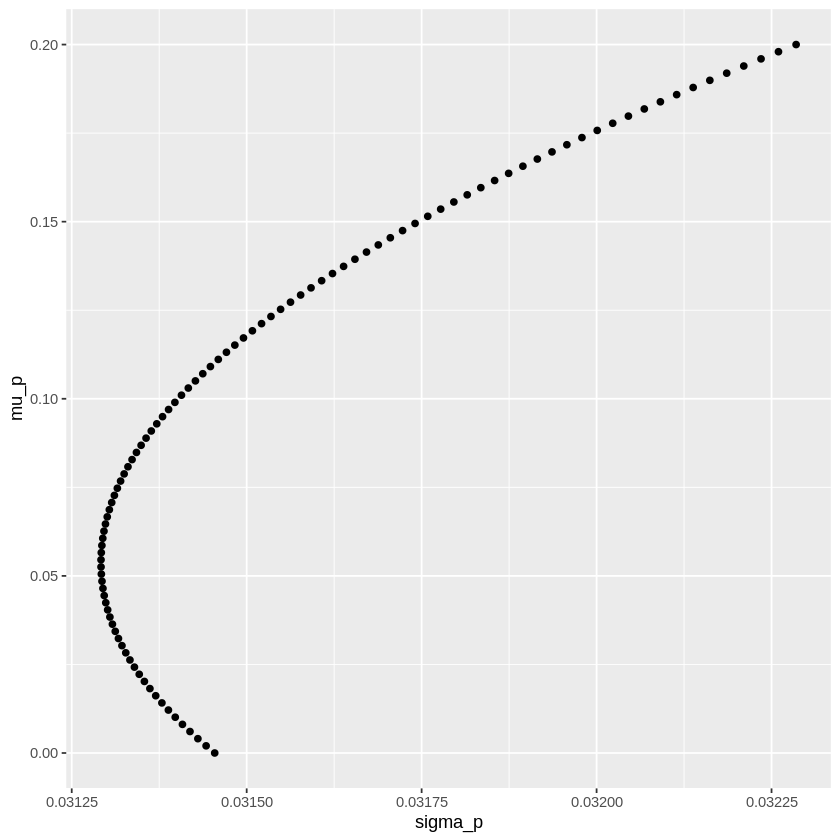

In [ ]:
ggplot(frontier.constr, aes(x = sigma_p, y = mu_p)) +
  geom_point()

In [ ]:

r <- 0.05
R <- exp(log(1 + r) / 252) - 1
sinv <- solve(sigma)
iota<- rep(1, length(mu))

a <- (mu %*% sinv %*% mu)[1]
b <- (mu %*% sinv %*% iota)[1]
d <- (iota %*% sinv %*% iota)[1]
det <- a*d - b^2
lambda <- (d*R - b)/det
nu <- (-b*R + a)/det
x <- sinv %*% (lambda * mu + nu * iota)

t(x) %*% iota

R
t(x) %*% mu

# a is very small compared to b, d (sharp/ratio is small)
a
b
d


sqrt(a)

sqrt(t(x) %*% sigma %*% x)*sqrt(252)

1


[1] 0.0001936305

0.0001936305


[1] 1.074752

[1] 53.39296

[1] 257359.1

[1] 1.036702

0.03129252


A Sharpe ratio less than 1 is considered bad. From 1 to 1.99 is considered adequate/good, from 2 to 2.99 is considered very good, and greater than 3 is considered excellent.